<a href="https://colab.research.google.com/github/KaiXiangC/Python_Factor-Investing_Final-Project/blob/main/D0939239%E8%91%89%E8%8A%B7%E5%9D%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 期末報告範例

- 以`台股上市櫃公司`為標的，只要有用到`AI模型(機器學習或深度學習)`，且有使用到`股票因子`作為輸入資料，產出`月換倉的投資組合`即可，其餘設定皆可自由調整。
- 投組績效計算期間為 `2022/01~2023/11`，對應大盤Benchmark為`台灣加權報酬指數`。
- 績效數字只是期末報告評分的參考之一，我們更重視報告的`邏輯架構和完整性` !


# 1.0 安裝套件 & 環境

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pandas.tseries.offsets import MonthEnd
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import xgboost #機器學習套件

plt.style.use('ggplot')
plt.rcParams.update({
    'font.weight': 'bold',
    'text.color': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k'})
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.0 股票因子計算

- 計算因子前，先檢查該欄位重複值、缺失值情況，並予以處理。若缺失值過多，會影響後續資料筆數和模型訓練。
- 根據課堂所學或其他方式，製作各類因子。
- 思考各因子背後的經濟邏輯，為何能透過其預測未來股價，並在報告時一併說明
- 這部份是投組績效最大的差異來源，也是期末報告評分佔比最大的一部份歐，大家加油 !

## 2.1 價量因子

In [ ]:
# 讀入台股價量資料
df_price = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')
df_price.head(100)

,證券名稱,資料日,市場別,開盤價,最高價,最低價,收盤價,成交量(千股),成交金額(元),成交筆數,周轉率,流通在外股數(千股),個股市值(元),市值比重,成交金額比重,現金股利率(TEJ),本益比(TEJ),股價淨值比(TEJ),股價營收比(TEJ)
0,1101台泥,2018-01-02,TWSE,36.45,36.60,36.05,20.444681,13698.0,499370945.0,3932.0,0.3226,4246509.0,1.552099e+11,0.485348,0.522,3.45,20.26,1.38,1.63
1,1102亞泥,2018-01-02,TWSE,28.30,28.40,28.05,19.734614,6669.0,187956859.0,2492.0,0.1984,3361447.0,9.479281e+10,0.296421,0.196,3.19,19.28,0.75,1.52
2,1103嘉泥,2018-01-02,TWSE,13.35,13.45,13.15,10.054507,1007.0,13406478.0,346.0,0.1300,774781.0,1.042080e+10,0.032586,0.014,1.49,173.87,0.61,4.01
3,1104環泥,2018-01-02,TWSE,23.00,23.05,22.90,16.405601,344.0,7919719.0,184.0,0.0526,653609.0,1.503301e+10,0.047009,0.008,5.07,10.07,0.93,3.31
4,1108幸福,2018-01-02,TWSE,8.35,8.40,8.35,7.062476,95.0,799475.0,51.0,0.0235,404738.0,3.399799e+09,0.010631,0.001,7.14,52.41,0.75,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1472三洋實業,2018-01-02,TWSE,41.90,42.50,41.50,139.028278,27.0,1130471.0,24.0,0.0633,42673.0,1.770918e+09,0.005538,0.001,0.00,NaN,5.09,2.27
96,1473台南,2018-01-02,TWSE,23.90,24.60,23.85,21.610337,342.0,8243717.0,146.0,0.2324,147154.0,3.619977e+09,0.011320,0.009,4.88,87.09,0.94,0.44
97,1474弘裕,2018-01-02,TWSE,11.40,11.40,11.30,9.432837,116.0,1318100.0,47.0,0.0893,129897.0,1.474331e+09,0.004610,0.001,5.29,13.43,0.80,0.45
98,1475業旺,2018-01-02,TWSE,48.20,48.20,45.00,41.648130,169.0,7779259.0,130.0,1.0552,16017.0,7.207540e+08,0.002254,0.008,0.00,NaN,2.74,4.73


In [ ]:
df_price.columns

Index(['證券名稱', '資料日', '市場別', '開盤價', '最高價', '最低價', '收盤價', '成交量(千股)', '成交金額(元)',
       '成交筆數', '周轉率', '流通在外股數(千股)', '個股市值(元)', '市值比重', '成交金額比重', '現金股利率(TEJ)',
       '本益比(TEJ)', '股價淨值比(TEJ)', '股價營收比(TEJ)'],
      dtype='object')

In [ ]:
df_mmt = df_price[['證券名稱','資料日','收盤價', '開盤價', '最高價', '最低價','個股市值(元)','成交金額比重','成交量(千股)']]

# 歷史報酬因子
# groupby:依照證券代碼分群 ； apply:套用計算函式 ； reset_index:groupby運算後回復原本排序
df_mmt['5日歷史報酬'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] / x['收盤價'].shift(5) - 1).reset_index(level=0,drop=True)
df_mmt['10日歷史報酬'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] / x['收盤價'].shift(10) - 1).reset_index(level=0,drop=True)
df_mmt['20日歷史報酬'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] / x['收盤價'].shift(20) - 1).reset_index(level=0,drop=True)
df_mmt['60日歷史報酬'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] / x['收盤價'].shift(60) - 1).reset_index(level=0,drop=True)
df_mmt['120日歷史報酬'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] / x['收盤價'].shift(120) - 1).reset_index(level=0,drop=True)

# 技術指標因子
#df_mmt['20日均量'] = df_mmt.groupby('證券名稱')['成交量(千股)'].rolling(20).mean().reset_index(level=0,drop=True)
df_mmt['每日漲跌幅'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] - x['收盤價'].shift(1)).reset_index(level=0,drop=True)
df_mmt['每日漲幅'] = df_mmt['每日漲跌幅'].apply(lambda x:x if x > 0 else 0)
df_mmt['每日跌幅'] = df_mmt['每日漲跌幅'].apply(lambda x:x if x < 0 else 0)

df_mmt['5日平均漲幅'] = df_mmt.groupby('證券名稱')['每日漲幅'].rolling(5).mean().reset_index(level=0,drop=True)
df_mmt['5日平均跌幅'] = df_mmt.groupby('證券名稱')['每日跌幅'].rolling(5).mean().reset_index(level=0,drop=True)
df_mmt['5日RS'] = df_mmt['5日平均漲幅'] / abs(df_mmt['5日平均跌幅'])
df_mmt['5日RSI'] = (df_mmt['5日RS'] / (1 + df_mmt['5日RS'])) *100

df_mmt['10日平均漲幅'] = df_mmt.groupby('證券名稱')['每日漲幅'].rolling(10).mean().reset_index(level=0,drop=True)
df_mmt['10日平均跌幅'] = df_mmt.groupby('證券名稱')['每日跌幅'].rolling(10).mean().reset_index(level=0,drop=True)
df_mmt['10日RS'] = df_mmt['10日平均漲幅'] / abs(df_mmt['10日平均跌幅'])
df_mmt['10日RSI'] = (df_mmt['10日RS'] / (1 + df_mmt['10日RS'])) *100

df_mmt['20日平均漲幅'] = df_mmt.groupby('證券名稱')['每日漲幅'].rolling(20).mean().reset_index(level=0,drop=True)
df_mmt['20日平均跌幅'] = df_mmt.groupby('證券名稱')['每日跌幅'].rolling(20).mean().reset_index(level=0,drop=True)
df_mmt['20日RS'] = df_mmt['20日平均漲幅'] / abs(df_mmt['20日平均跌幅'])
df_mmt['20日RSI'] = (df_mmt['20日RS'] / (1 + df_mmt['20日RS'])) *100

df_mmt['60日平均漲幅'] = df_mmt.groupby('證券名稱')['每日漲幅'].rolling(60).mean().reset_index(level=0,drop=True)
df_mmt['60日平均跌幅'] = df_mmt.groupby('證券名稱')['每日跌幅'].rolling(60).mean().reset_index(level=0,drop=True)
df_mmt['60日RS'] = df_mmt['60日平均漲幅'] / abs(df_mmt['60日平均跌幅'])
df_mmt['60日RSI'] = (df_mmt['60日RS'] / (1 + df_mmt['60日RS'])) *100

df_mmt['120日平均漲幅'] = df_mmt.groupby('證券名稱')['每日漲幅'].rolling(120).mean().reset_index(level=0,drop=True)
df_mmt['120日平均跌幅'] = df_mmt.groupby('證券名稱')['每日跌幅'].rolling(120).mean().reset_index(level=0,drop=True)
df_mmt['120日RS'] = df_mmt['120日平均漲幅'] / abs(df_mmt['120日平均跌幅'])
df_mmt['120日RSI'] = (df_mmt['120日RS'] / (1 + df_mmt['120日RS'])) *100



In [ ]:
#黃金切割率
df_mmt['前方低點']= df_mmt.groupby('證券名稱')['最低價'].expanding().min().reset_index(level=0,drop=True)
df_mmt['前方高點']= df_mmt.groupby('證券名稱')['最高價'].expanding().max().reset_index(level=0,drop=True)
df_mmt['Fib_382'] = (df_mmt['前方高點'] - df_mmt['前方低點']) * 0.382 + df_mmt['前方低點']
df_mmt['Fib_618'] = (df_mmt['前方高點'] - df_mmt['前方低點']) * 0.618 + df_mmt['前方低點']


# 驗證計算結果
df_mmt[df_mmt['證券名稱'] == '1101台泥'].head()

,證券名稱,資料日,收盤價,開盤價,最高價,最低價,個股市值(元),成交金額比重,成交量(千股),5日歷史報酬,...,60日RS,60日RSI,120日平均漲幅,120日平均跌幅,120日RS,120日RSI,前方低點,前方高點,Fib_382,Fib_618
0,1101台泥,2018-01-02,20.444681,36.45,36.60,36.05,1.552099e+11,0.522,13698.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,36.05,36.60,36.2601,36.3899
1547,1101台泥,2018-01-03,20.892171,36.50,37.35,36.25,1.586071e+11,0.565,19959.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,36.05,37.35,36.5466,36.8534
3094,1101台泥,2018-01-04,20.808266,37.35,37.45,36.75,1.579701e+11,0.414,14927.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,36.05,37.45,36.5848,36.9152
4643,1101台泥,2018-01-05,20.864203,37.50,37.50,37.05,1.583948e+11,0.992,35536.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,36.05,37.50,36.6039,36.9461
6192,1101台泥,2018-01-08,21.367628,37.40,38.30,37.20,1.622166e+11,0.659,22660.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,36.05,38.30,36.9095,37.4405


In [ ]:
print(df_mmt.describe())

                收盤價           開盤價           最高價           最低價       個股市值(元)  \
count  2.338403e+06  2.338403e+06  2.338403e+06  2.338403e+06  2.338403e+06   
mean   5.188193e+01  5.821203e+01  5.903087e+01  5.734008e+01  2.747258e+10   
std    1.172489e+02  1.307081e+02  1.328979e+02  1.282894e+02  2.964481e+11   
min    1.300000e-01  1.300000e-01  1.400000e-01  1.300000e-01  5.011400e+07   
25%    1.577143e+01  1.700000e+01  1.720000e+01  1.680000e+01  1.610462e+09   
50%    2.703717e+01  3.010000e+01  3.045000e+01  2.980000e+01  3.746705e+09   
75%    5.161833e+01  5.860000e+01  5.930000e+01  5.790000e+01  1.069527e+10   
max    4.514375e+03  5.260000e+03  5.330000e+03  5.175000e+03  1.771045e+13   

             成交金額比重       成交量(千股)        5日歷史報酬       10日歷史報酬       20日歷史報酬  \
count  2.301902e+06  2.338403e+06  2.329611e+06  2.320824e+06  2.303272e+06   
mean   1.197346e-01  2.513750e+03  3.308056e-03  6.649732e-03  1.321260e-02   
std    5.358038e-01  1.258913e+04  5.700579e-02  8.

In [ ]:
# 找到第一筆資料的個股市值2的值
first_row_values = df_mmt.groupby('證券名稱').first()

# 提取第一筆資料中 '個股市值(元)' 的值
replacement_value = first_row_values['個股市值(元)']

# 將整個 '個股市值2' 列的值都替換為第一筆資料的值
df_mmt['個股市值2'] = df_mmt['證券名稱'].map(replacement_value)

# 檢查結果
df_mmt.tail()

,證券名稱,資料日,收盤價,開盤價,最高價,最低價,個股市值(元),成交金額比重,成交量(千股),5日歷史報酬,...,60日RSI,120日平均漲幅,120日平均跌幅,120日RS,120日RSI,前方低點,前方高點,Fib_382,Fib_618,個股市值2
2338398,9951皇田,2023-11-30,78.00,77.00,78.30,76.90,5.842200e+09,0.011,128.0,0.012987,...,54.462243,0.422358,-0.351030,1.203198,54.611433,49.45,175.50,97.60110,127.34890,1.280790e+10
2338399,9955佳龍,2023-11-30,24.90,25.55,25.60,24.90,2.569885e+09,0.006,961.0,0.052854,...,55.156951,0.187500,-0.195000,0.961538,49.019608,10.90,35.50,20.29720,26.10280,1.661652e+09
2338400,9958世紀鋼,2023-11-30,166.00,167.00,168.50,165.50,3.917132e+10,0.079,1889.0,0.012195,...,51.521739,1.988558,-1.539748,1.291483,56.360131,21.40,194.50,87.52420,128.37580,4.323504e+09
2338401,9960邁達康,2023-11-30,26.95,27.15,27.15,26.75,9.053180e+08,0.001,22.0,-0.007366,...,50.773994,0.106012,-0.118747,0.892748,47.166774,23.15,38.45,28.99460,32.60540,1.221087e+09
2338402,9962有益,2023-11-30,17.80,17.95,17.95,17.80,1.605921e+09,0.002,109.0,-0.011111,...,53.543307,0.060000,-0.080000,0.750000,42.857143,6.31,26.00,13.83158,18.47842,9.292690e+08


## 2.2 籌碼因子

In [ ]:
# 讀入台股籌碼資料
df_chip = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//籌碼資料.feather')
df_chip.head()

,證券名稱,資料日,市場別,外資買進張數,外資賣出張數,外資買賣超張數,外資買進金額(元),外資賣出金額(元),外資買賣超金額(元),外資持股率,...,融券餘額(元),資券比,資券互抵,資券互抵(元),借券賣出,借券賣出(元),借券餘額,借券餘額(元),當沖成交股數(千股),當沖買賣占比
0,1101台泥,2018-01-02,TWSE,3969.0,3563.0,406.0,145067.0,130228.0,14839.0,32.54,...,18408.87,6.66,0.0,0.0,19.0,692.61,15016.0,547381.25,558.0,4.07
1,1102亞泥,2018-01-02,TWSE,1091.0,73.0,1019.0,30766.0,2059.0,28736.0,19.42,...,1916.25,1.82,0.0,0.0,1.0,28.18,7239.0,203995.74,329.0,4.93
2,1103嘉泥,2018-01-02,TWSE,1.0,114.0,-113.0,13.0,1533.0,-1520.0,3.08,...,465.71,0.95,0.0,0.0,0.0,0.00,1580.0,21023.64,53.0,5.26
3,1104環泥,2018-01-02,TWSE,132.0,112.0,20.0,3036.0,2576.0,460.0,17.97,...,68.97,0.20,0.0,0.0,0.0,0.00,841.0,19333.58,0.0,0.00
4,1108幸福,2018-01-02,TWSE,0.0,0.0,0.0,0.0,0.0,0.0,2.35,...,0.00,0.00,0.0,0.0,0.0,0.00,667.0,5593.13,0.0,0.00


In [ ]:
df_chip.columns

Index(['證券名稱', '資料日', '市場別', '外資買進張數', '外資賣出張數', '外資買賣超張數', '外資買進金額(元)',
       '外資賣出金額(元)', '外資買賣超金額(元)', '外資持股率', '投信買進張數', '投信賣出張數', '投信買賣超張數',
       '投信買進金額(元)', '投信賣出金額(元)', '投信買賣超金額(元)', '投信持股率', '自營商買進張數(自行)',
       '自營商賣出張數(自行)', '自營買賣超張數(自行)', '自營商買進金額(自行)', '自營商賣出金額(自行)',
       '自營買賣超金額(自行)', '自營商買進張數(避險)', '自營商賣出張數(避險)', '自營買賣超張數(避險)',
       '自營商買進金額(避險)', '自營商賣出金額(避險)', '自營買賣超金額(避險)', '自營商持股率', '合計買進張數',
       '合計賣出張數', '合計買賣超張數', '合計買進金額(元)', '合計賣出金額(元)', '合計買賣超金額(元)', '融資買進',
       '融資賣出', '融資餘額', '融資餘額(元)', '融券買進', '融券賣出', '融券餘額', '融券餘額(元)', '資券比',
       '資券互抵', '資券互抵(元)', '借券賣出', '借券賣出(元)', '借券餘額', '借券餘額(元)', '當沖成交股數(千股)',
       '當沖買賣占比'],
      dtype='object')

In [ ]:
df_chip['三大法人買賣超金額'] = df_chip['外資買賣超金額(元)'] + df_chip['投信買賣超金額(元)'] + df_chip['自營買賣超金額(自行)'] + df_chip['自營買賣超金額(避險)']

# 驗證計算結果
df_chip[['證券名稱', '資料日','外資買賣超金額(元)','投信買賣超金額(元)','自營買賣超金額(自行)','自營買賣超金額(避險)','三大法人買賣超金額']].head()

,證券名稱,資料日,外資買賣超金額(元),投信買賣超金額(元),自營買賣超金額(自行),自營買賣超金額(避險),三大法人買賣超金額
0,1101台泥,2018-01-02,14839.0,26755.0,14035.0,-2010.0,53619.0
1,1102亞泥,2018-01-02,28736.0,649.0,761.0,0.0,30146.0
2,1103嘉泥,2018-01-02,-1520.0,0.0,0.0,0.0,-1520.0
3,1104環泥,2018-01-02,460.0,0.0,0.0,0.0,460.0
4,1108幸福,2018-01-02,0.0,0.0,0.0,0.0,0.0


## 2.3 月營收因子

In [ ]:
# 讀入台股月營收資料
df_sales = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//月營收資料.feather')
df_sales.drop_duplicates(subset=['證券名稱','營收發布日'],inplace=True)
df_sales = df_sales.reset_index(drop=True)
df_sales.head()

,證券名稱,年月,營收發布日,單月營收(千元),去年單月營收(千元),單月營收成長率％,單月營收與上月比％,累計營收(千元),去年累計營收(千元),累計營收成長率％,...,與歷史最高單月營收比%,歷史最低單月營收(千元),與歷史最低單月營收比%,近12月累計營收(千元),去年近12月累計營收(千元),近12月累計營收成長率％,近 3月累計營收(千元),去年近 3月累計營收(千元),近3月累計營收成長率％,近3月累計營收與上月比％
0,1101台泥,2018-01-01,2018-02-12,9617393.0,6131670.0,56.85,-12.47,9617393.0,6131670.0,56.85,...,-16.82,3632053.0,164.79,101799228.0,89127748.0,14.22,30591439.0,24417239.0,25.29,4.19
1,1102亞泥,2018-01-01,2018-02-09,6769986.0,4162130.0,62.66,-4.25,6769986.0,4162130.0,62.66,...,-10.78,2552357.0,165.24,67507039.0,60068678.0,12.38,20479859.0,15517862.0,31.98,4.76
2,1103嘉泥,2018-01-01,2018-02-12,172094.0,232657.0,-26.03,-4.98,172094.0,232657.0,-26.03,...,-83.36,132940.0,29.45,2035321.0,3175398.0,-35.90,535074.0,969076.0,-44.79,0.89
3,1104環泥,2018-01-01,2018-02-09,460482.0,363865.0,26.55,15.18,460482.0,363865.0,26.55,...,-16.62,293590.0,56.85,4501993.0,4612753.0,-2.40,1241843.0,1238222.0,0.29,11.12
4,1108幸福,2018-01-01,2018-02-09,320340.0,316773.0,1.13,9.87,320340.0,316773.0,1.13,...,-38.26,232100.0,38.02,3406838.0,4219568.0,-19.26,870824.0,1010162.0,-13.79,7.47


In [ ]:
df_sales.columns

Index(['證券名稱', '年月', '營收發布日', '單月營收(千元)', '去年單月營收(千元)', '單月營收成長率％',
       '單月營收與上月比％', '累計營收(千元)', '去年累計營收(千元)', '累計營收成長率％', '歷史最高單月營收(千元)',
       '與歷史最高單月營收比%', '歷史最低單月營收(千元)', '與歷史最低單月營收比%', '近12月累計營收(千元)',
       '去年近12月累計營收(千元)', '近12月累計營收成長率％', '近 3月累計營收(千元)', '去年近 3月累計營收(千元)',
       '近3月累計營收成長率％', '近3月累計營收與上月比％'],
      dtype='object')

In [ ]:
df_sales['月營收_MoM'] = df_sales.groupby('證券名稱').apply(lambda x: (x['單月營收(千元)'] - x['單月營收(千元)'].shift(1)) / x['單月營收(千元)'].shift(1)).reset_index(level=0,drop=True)
df_sales['月營收_YoY'] = df_sales.groupby('證券名稱').apply(lambda x: (x['單月營收(千元)'] - x['單月營收(千元)'].shift(12)) / x['單月營收(千元)'].shift(12)).reset_index(level=0,drop=True)
# 計算近3月營收YoY
df_sales['近3月營收'] = df_sales.groupby('證券名稱')['單月營收(千元)'].rolling(3).sum().reset_index(level=0,drop=True)
df_sales['近3月營收_YoY'] = df_sales.groupby('證券名稱').apply(lambda x: (x['近3月營收'] - x['近3月營收'].shift(12)) / x['近3月營收'].shift(12)).reset_index(level=0,drop=True)

# 驗證計算結果
df_sales[df_sales['證券名稱'] == '1101台泥'][['證券名稱', '營收發布日', '單月營收(千元)', '月營收_MoM', '月營收_YoY', '近3月營收_YoY', '近3月累計營收成長率％']].tail()

,證券名稱,營收發布日,單月營收(千元),月營收_MoM,月營收_YoY,近3月營收_YoY,近3月累計營收成長率％
120833,1101台泥,2023-07-10,8816109.0,-0.081281,-0.036068,0.091797,9.18
122835,1101台泥,2023-08-10,8953462.0,0.015580,-0.113735,0.014210,1.42
124844,1101台泥,2023-09-11,9379408.0,0.047573,-0.122588,-0.093169,-9.32
126856,1101台泥,2023-10-11,8735157.0,-0.068688,-0.160477,-0.132358,-13.24
128873,1101台泥,2023-11-10,9371746.0,0.072877,-0.175610,-0.153300,-15.33


## 2.4 財報因子

In [ ]:
# 讀入台股季財報資料
df_fin = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//季財報資料.feather')
df_fin.drop_duplicates(subset=['證券名稱','編表日'],inplace=True)
df_fin = df_fin.reset_index(drop=True)
df_fin.head()

,證券名稱,年/月,期間別,序號,季別,合併(Y/N),幣別,編表日,產業別,現金及約當現金,...,固定資產週轉率,期末收帳天數,期末付帳天數,期末售貨天數,每股淨值,每股營業收入,每股營業利益,每股稅前淨利,每股稅後淨利,每人營收
0,1101台泥,2018-03-01,Q,001,1,Y,TWD,2018-05-15,F,24192833.0,...,0.19,227.60,37.62,45.58,35.21,5.69,1.10,1.09,0.67,2584.35
1,1102亞泥,2018-03-01,Q,001,1,Y,TWD,2018-05-15,F,10204539.0,...,0.29,143.69,47.32,47.76,38.54,5.31,0.80,0.91,0.72,2991.07
2,1103嘉泥,2018-03-01,Q,001,1,Y,TWD,2018-05-14,F,1498081.0,...,0.15,35.59,39.75,155.75,23.51,0.61,-0.07,0.25,0.21,2076.02
3,1104環泥,2018-03-01,Q,001,1,Y,TWD,2018-05-14,F,228393.0,...,0.18,75.41,42.91,26.81,26.89,1.78,0.08,0.02,0.00,NaN
4,1108幸福,2018-03-01,Q,001,1,Y,TWD,2018-05-15,F,199622.0,...,0.51,67.40,42.44,411.16,10.84,2.06,-0.09,-0.08,-0.02,1682.23


In [ ]:
df_fin.columns

Index(['證券名稱', '年/月', '期間別', '序號', '季別', '合併(Y/N)', '幣別', '編表日', '產業別',
       '現金及約當現金',
       ...
       '固定資產週轉率', '期末收帳天數', '期末付帳天數', '期末售貨天數', '每股淨值', '每股營業收入', '每股營業利益',
       '每股稅前淨利', '每股稅後淨利', '每人營收'],
      dtype='object', length=106)

In [ ]:
# 計算營利率YoY
df_fin['營利率'] = df_fin['營業利益'] / df_fin['營業收入']
df_fin['營利率_YoY'] = df_fin.groupby('證券名稱').apply(lambda x: (x['營利率'] - x['營利率'].shift(4)) / x['營利率'].shift(4)).reset_index(level=0,drop=True)

# 計算每股稅後淨利_YoY
df_fin['每股稅後淨利_YoY'] = df_fin.groupby('證券名稱').apply(lambda x: (x['每股稅後淨利'] - x['每股稅後淨利'].shift(4)) / x['每股稅後淨利'].shift(4)).reset_index(level=0,drop=True)

# 驗證計算結果
df_fin[df_fin['證券名稱'] == '1101台泥'][['證券名稱', '編表日', '營利率', '營利率_YoY', '每股稅後淨利', '每股稅後淨利_YoY']].tail()

,證券名稱,編表日,營利率,營利率_YoY,每股稅後淨利,每股稅後淨利_YoY
28874,1101台泥,2022-11-10,0.020163,-0.859437,0.24,-0.652174
30527,1101台泥,2023-02-24,0.067368,-0.566101,0.36,-0.555556
32192,1101台泥,2023-05-11,0.006315,-0.301211,0.14,0.000000
33863,1101台泥,2023-08-10,0.121737,-2.526675,0.59,-4.933333
35540,1101台泥,2023-11-10,0.113410,4.624641,0.32,0.333333


##2.5 F score 因子



In [ ]:
# 讀入F score
#df_score_xlsx = pd.read_excel('/content/drive/MyDrive/FCU_20231208/Fscore.xlsx',sheet_name='F2')
#df_score_xlsx.to_feather('df_score.feather')
#df_score = pd.read_feather('df_score.feather')
#df_score.to_feather('/content/drive/MyDrive/FCU_20231208/df_score.feather')
df_score = pd.read_feather('/content/drive/MyDrive/FCU_20231208/df_score.feather')
df_score.drop_duplicates(subset=['證券名稱','財報發布日'],inplace=True)
df_score = df_score.reset_index(drop=True)
df_score.head()


,證券名稱,年月,保留盈餘,流動比率,負債比率,總資產週轉次數,總資產報酬成長率,總資產成長率,資產總額,加權平均股數,...,營業毛利率,流動負債,一年內到期長期負債,股本,季底普通股市值,每股淨值(F)－TSE公告數,淨值成長率,總負債/總淨值,淨值/資產,財報發布日
0,1101台泥,201803,51870788,141.05,41.45,0.35,0.62,9.07,283088584,4244509.0,...,23.95,53357480.0,8754600.0,42465090,155209904.0,35.26,12.34,70.78,58.55,2018/05/15
1,1102亞泥,201803,97806689,106.81,40.52,0.29,0.85,3.03,249899869,3139175.0,...,18.67,50810456.0,5125291.0,33614472,95969312.0,38.54,7.41,68.13,59.48,2018/05/15
2,1103嘉泥,201803,9511808,347.76,32.10,0.07,0.87,14.52,29494843,643555.0,...,11.63,2707627.0,720896.0,7747805,9026187.0,28.30,19.69,47.27,67.90,2018/05/14
3,1104環泥,201803,10235852,139.06,18.86,0.22,-1.32,7.29,21801660,653609.0,...,11.88,2790203.0,0.0,6536092,14575481.0,26.89,7.88,23.25,81.14,2018/05/14
4,1108幸福,201803,350333,268.59,38.36,0.46,-0.44,-5.89,7155857,404738.0,...,2.47,1868350.0,111200.0,4047380,3148862.0,10.84,-8.26,62.24,61.64,2018/05/15


In [ ]:
df_score.columns

Index(['證券名稱', '年月', '  保留盈餘', '流動比率', '負債比率', '總資產週轉次數', '總資產報酬成長率', '總資產成長率',
       '資產總額', '加權平均股數', '本期產生現金流量', '自由現金流量(D)', 'ROA－綜合損益', 'ROE－綜合損益',
       '營業毛利率', '流動負債', '  一年內到期長期負債', '  股本', '季底普通股市值', '每股淨值(F)－TSE公告數',
       '淨值成長率', '總負債/總淨值', '淨值/資產', '財報發布日'],
      dtype='object')



```
# 此內容會顯示為程式碼
```

##2.6 黃金分割率因子



In [ ]:
df_price = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')
if type(df_price) != pd.DataFrame:
  df_price = pd.DataFrame(df_price)
df_price.head()

company_stats = df_price.groupby('證券名稱')['收盤價'].agg(['max', 'min'])

print(company_stats)
company_stats['Fib_382'] = (company_stats['max'] - company_stats['min'])*0.382+company_stats['min']
company_stats['Fib_618'] = (company_stats['max'] - company_stats['min'])*0.618+company_stats['min']

# 顯示結果
print(company_stats)


In [ ]:
# 使用 pandas pivot 轉換為 index=資料日, columns=證券名稱, values=收盤價
df_price.pivot(index='資料日', columns='證券名稱', values='收盤價')

證券名稱,1101台泥,1102亞泥,1103嘉泥,1104環泥,1108幸福,1109信大,1110東泥,1201味全,1203味王,1210大成,...,9944新麗,9945潤泰新,9946三發地產,9949琉園,9950萬國通,9951皇田,9955佳龍,9958世紀鋼,9960邁達康,9962有益
資料日,,,,,,,,,,,,,,,,,,,,,
2018-01-02,20.444681,19.734614,10.054507,16.405601,7.062476,10.158556,14.071296,18.103084,20.451938,21.770103,...,17.167792,13.676128,8.362659,11.20,13.60,128.175786,16.10,21.134498,29.138487,7.501068
2018-01-03,20.892171,19.874576,9.942375,16.405601,7.020438,10.422905,13.975246,17.931083,20.532776,21.543668,...,17.167792,13.847080,8.766802,11.20,13.65,127.801003,15.80,23.220736,29.659533,7.537481
2018-01-04,20.808266,20.014537,9.942375,16.405601,7.045661,10.385141,13.927221,18.060084,20.613613,21.705407,...,17.124108,13.911186,8.518098,11.25,13.75,127.426220,15.50,25.533739,29.058326,7.573894
2018-01-05,20.864203,20.539394,10.166639,16.476930,7.045661,10.536198,13.831171,18.103084,20.694451,21.608364,...,17.036741,14.146245,8.518098,11.20,13.75,126.301871,15.80,28.073507,29.900016,7.573894
2018-01-08,21.367628,21.204213,10.316149,16.512594,7.062476,10.536198,13.783146,18.834088,20.654032,21.996538,...,16.949373,14.231721,8.580274,11.15,14.00,127.426220,16.00,30.840040,27.976154,7.537481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,33.750000,41.600000,18.950000,28.050000,14.900000,17.950000,18.800000,19.300000,49.250000,55.300000,...,19.700000,35.850000,20.300000,14.15,27.25,76.800000,23.65,173.500000,27.150000,17.950000
2023-11-27,33.950000,41.800000,18.950000,28.050000,14.900000,18.250000,18.950000,19.100000,49.500000,55.000000,...,20.550000,35.500000,20.200000,15.15,26.35,76.400000,24.05,166.500000,27.000000,17.750000
2023-11-28,34.500000,42.100000,19.050000,28.550000,15.100000,18.200000,19.000000,19.300000,50.100000,55.800000,...,20.250000,35.850000,20.650000,15.15,26.60,76.800000,24.40,166.500000,27.050000,17.950000


In [ ]:
df_price.pivot(index='資料日', columns='證券名稱', values='收盤價')[['1101台泥']]

證券名稱,1101台泥
資料日,
2018-01-02,20.444681
2018-01-03,20.892171
2018-01-04,20.808266
2018-01-05,20.864203
2018-01-08,21.367628
...,...
2023-11-24,33.750000
2023-11-27,33.950000
2023-11-28,34.500000


# 3.0 合併各類因子資料
- 根據前一部份計算整理，列出想要放入模型的因子 (需保留`收盤價`欄位)
- 合併部份基本無需更動，確認最後產出之dataframe無缺失值、重複值、inf(無限大值)，且資料合理即可




In [ ]:
####################
# 根據前一部份計算整理，列出想要放入模型的因子
# 需保留'收盤價'欄位，以計算個股下期報酬，供模型訓練
####################

df_mmt_s = df_mmt[['證券名稱', '資料日' ,'收盤價','10日歷史報酬','20日歷史報酬','60日歷史報酬','120日歷史報酬','10日RSI','20日RSI','60日RSI','120日RSI']]
#
df_chip_s = df_chip[['證券名稱', '資料日','三大法人買賣超金額']]
df_sales_s = df_sales[['證券名稱', '營收發布日', '月營收_MoM', '月營收_YoY']]
df_fin_s = df_fin[['證券名稱', '編表日','營利率_YoY','每股稅後淨利_YoY']]

df_score_s = df_score[['證券名稱', '財報發布日','ROA－綜合損益']]
#,'總資產週轉次數'150%
#'資產總額',, '本期產生現金流量', ,
       #, '流動負債', '  一年內到期長期負債', '  股本', '季底普通股市值', '每股淨值(F)－TSE公告數',
       #, '總負債/總淨值', '淨值/資產', 'ROE－綜合損益',

In [ ]:
# 將價量以外因子(籌碼、月營收、財報因子)，mapping至日頻率
df_chip_s['資料日'] = pd.to_datetime(df_chip_s['資料日'])
df_chip_s.set_index('資料日', inplace=True)
df_chip_s = df_chip_s.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_chip_s = df_chip_s.sort_values(by=['證券名稱','資料日']).reset_index()

df_sales_s['營收發布日'] = pd.to_datetime(df_sales_s['營收發布日'])
df_sales_s.set_index('營收發布日', inplace=True)
df_sales_s = df_sales_s.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_sales_s = df_sales_s.sort_values(by=['證券名稱','營收發布日']).reset_index()

df_fin_s['編表日'] = pd.to_datetime(df_fin_s['編表日'])
df_fin_s.set_index('編表日', inplace=True)
df_fin_s = df_fin_s.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_fin_s = df_fin_s.sort_values(by=['證券名稱','編表日']).reset_index()

df_score_s['財報發布日'] = pd.to_datetime(df_score_s['財報發布日'])
df_score_s.set_index('財報發布日', inplace=True)
df_score_s = df_score_s.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_score_s = df_score_s.sort_values(by=['證券名稱','財報發布日']).reset_index()

In [ ]:
# 以價量資料(台股交易日)為基準，合併不同頻率之資料
df_all_factor = df_mmt_s.copy()

# merge: 合併兩個dataframe，on=合併基準欄位，how=以哪個dataframe為準)
df_all_factor = pd.merge(df_all_factor, df_chip_s, on=['證券名稱', '資料日'], how='left')
df_all_factor = pd.merge(df_all_factor, df_sales_s, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '營收發布日'], how='left')
df_all_factor = pd.merge(df_all_factor, df_fin_s, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '編表日'], how='left')
df_all_factor = pd.merge(df_all_factor, df_score_s, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '財報發布日'], how='left')
df_all_factor.drop(columns=['營收發布日','編表日','財報發布日'],inplace=True)


df_all_factor


,證券名稱,資料日,收盤價,10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,60日RSI,120日RSI,三大法人買賣超金額,月營收_MoM,月營收_YoY,營利率_YoY,每股稅後淨利_YoY,ROA－綜合損益
0,1101台泥,2018-01-02,20.444681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53619.0,NaN,NaN,NaN,NaN,NaN
1,1102亞泥,2018-01-02,19.734614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30146.0,NaN,NaN,NaN,NaN,NaN
2,1103嘉泥,2018-01-02,10.054507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1520.0,NaN,NaN,NaN,NaN,NaN
3,1104環泥,2018-01-02,16.405601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,460.0,NaN,NaN,NaN,NaN,NaN
4,1108幸福,2018-01-02,7.062476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338398,9951皇田,2023-11-30,78.000000,0.001284,0.056911,0.052632,0.123263,51.162791,67.213115,54.462243,54.611433,1950.0,NaN,NaN,NaN,NaN,NaN
2338399,9955佳龍,2023-11-30,24.900000,0.044025,-0.013861,0.101770,-0.034884,66.153846,47.154472,55.156951,49.019608,-647.0,NaN,NaN,NaN,NaN,NaN
2338400,9958世紀鋼,2023-11-30,166.000000,-0.023529,0.189964,0.044025,0.480255,43.750000,68.531469,51.521739,56.360131,53547.0,NaN,NaN,NaN,NaN,NaN
2338401,9960邁達康,2023-11-30,26.950000,-0.005535,0.038536,0.009363,-0.053666,41.176471,68.518519,50.773994,47.166774,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_all_factor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2338403 entries, 0 to 2338402
Data columns (total 17 columns):
 #   Column      Dtype         
---  ------      -----         
 0   證券名稱        object        
 1   資料日         datetime64[ns]
 2   收盤價         float64       
 3   10日歷史報酬     float64       
 4   20日歷史報酬     float64       
 5   60日歷史報酬     float64       
 6   120日歷史報酬    float64       
 7   10日RSI      float64       
 8   20日RSI      float64       
 9   60日RSI      float64       
 10  120日RSI     float64       
 11  三大法人買賣超金額   float64       
 12  月營收_MoM     float64       
 13  月營收_YoY     float64       
 14  營利率_YoY     float64       
 15  每股稅後淨利_YoY  float64       
 16  ROA－綜合損益    float64       
dtypes: datetime64[ns](1), float64(15), object(1)
memory usage: 321.1+ MB


In [ ]:
# 把inf(無限大)填補成缺失值，以利後續一併刪除
df_all_factor.replace([np.inf, -np.inf], np.NaN, inplace=True)

# 刪除含有缺失值之資料行 (若缺失值過多，這步驟會刪掉很多資料，導致後續資料筆數太少，務必在因子計算時先行處理)
df_all_factor.dropna(inplace=True)
df_all_factor = df_all_factor.sort_values(by=['證券名稱','資料日']).reset_index(level=0,drop=True)

In [ ]:
#df_all_1 = df_all_factor.copy()



#df_all_1 = df_all_1.sort_values(['三大法人買賣超金額'],ascending=[1,0])
#df_all_factor = df_all_1[df_all_1['資料日']=='2023-11-01'].sort_values(by='個股市值(元)', ascending=False).head(1000)
#df_all_factor
#df_all_1.head(10)

In [ ]:
df_all_factor.tail()

,證券名稱,資料日,收盤價,10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,60日RSI,120日RSI,三大法人買賣超金額,月營收_MoM,月營收_YoY,營利率_YoY,每股稅後淨利_YoY,ROA－綜合損益
1716555,9962有益,2023-11-07,17.70,0.029070,0.032070,0.020173,-0.106061,77.777778,66.666667,52.554745,44.067797,372.0,-0.168997,-0.235536,-0.501382,-0.528571,4.83
1716556,9962有益,2023-11-08,17.50,0.008646,0.017442,0.005747,-0.122807,57.894737,58.333333,50.714286,43.098592,193.0,-0.168997,-0.235536,-0.501382,-0.528571,4.83
1716557,9962有益,2023-11-09,17.45,0.008671,0.008671,0.032544,-0.123116,57.894737,54.285714,54.198473,43.098592,-925.0,-0.168997,-0.235536,-0.501382,-0.528571,4.83
1716558,9962有益,2023-11-10,17.40,0.005780,0.008696,0.014577,-0.125628,55.000000,54.285714,51.968504,42.977528,-400.0,-0.168997,-0.235536,-0.501382,-0.528571,4.83
1716559,9962有益,2023-11-13,17.35,0.005797,0.008721,0.005797,-0.110256,55.000000,54.285714,50.793651,43.839542,-746.0,-0.168997,-0.235536,-0.524898,-0.522388,6.63


In [ ]:
df_all_factor.isnull().sum()

證券名稱          0
資料日           0
收盤價           0
10日歷史報酬       0
20日歷史報酬       0
60日歷史報酬       0
120日歷史報酬      0
10日RSI        0
20日RSI        0
60日RSI        0
120日RSI       0
三大法人買賣超金額     0
月營收_MoM       0
月營收_YoY       0
營利率_YoY       0
每股稅後淨利_YoY    0
ROA－綜合損益      0
dtype: int64

# 4.0 XGBoost選股模型

- XGBoost模型架構無需更動。若想調整參數，可參考以下資料:
  - 官方文檔 : https://xgboost.readthedocs.io/en/stable/python/
  - https://ithelp.ithome.com.tw/articles/10273094
  - https://medium.com/@pahome.chen/xgboost%E5%85%A5%E9%96%80%E7%B6%93%E9%A9%97%E5%88%86%E4%BA%AB-e06931b835f5

- 除XGBoost模型外，也可在模型前或模型後，加入其他選股方式，或許有奇效。例如: 市值大小過濾、成交量過濾......

- 每期投組股票檔數`(portfolio_stock_num)`可以調整，預設10檔。

In [ ]:
# 特徵集合(因子集合)
feature_list = df_all_factor.columns.drop(['證券名稱','資料日','收盤價'])

# 取每月第一個交易日的資料
df_feature = df_all_factor.copy()
df_feature['年月'] = df_feature['資料日'].dt.strftime('%Y-%m')
reb_date_all = df_feature[['年月','資料日']].sort_values(by='資料日').drop_duplicates(subset=['年月'], keep = 'first').reset_index(drop=True)
df_feature_m = df_feature[df_feature['資料日'].isin(reb_date_all['資料日'])].copy().reset_index(drop=True)

In [ ]:
# 因子標準化
def standardize(x):
    return (x - x.mean()) / x.std()

df_feature_m[feature_list] = df_feature_m.groupby('資料日')[feature_list].apply(standardize).reset_index(level=0,drop=True)
df_feature_m.tail()

,證券名稱,資料日,收盤價,10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,60日RSI,120日RSI,三大法人買賣超金額,月營收_MoM,月營收_YoY,營利率_YoY,每股稅後淨利_YoY,ROA－綜合損益,年月
84438,9962有益,2023-07-03,20.25,-0.111012,0.003580,-0.360289,0.015133,0.281757,0.776951,-0.323645,0.238572,-0.027630,-0.024816,-0.028520,0.030696,0.142167,0.904903,2023-07
84439,9962有益,2023-08-01,18.45,0.064418,-0.819517,-0.733818,-0.444690,0.272389,-1.226238,-1.238467,-0.425880,-0.004368,-0.038055,0.014423,0.030387,0.136706,0.804530,2023-08
84440,9962有益,2023-09-01,17.25,-0.516357,-0.633502,-0.842526,-0.789015,-0.883490,-1.194701,-1.534135,-1.105569,0.040462,-0.055683,-0.026951,-0.056590,-0.039297,0.605624,2023-09
84441,9962有益,2023-10-02,17.10,-0.677405,-0.216091,-0.755021,-0.929805,-2.126747,-0.121790,-1.291702,-1.557436,-0.064731,0.084245,-0.054893,-0.056304,-0.039321,0.604306,2023-10
84442,9962有益,2023-11-01,17.15,0.196112,0.251690,-0.315683,-0.774379,1.163115,0.657746,-0.723310,-1.513922,0.018598,-0.027324,-0.028679,-0.055216,-0.055924,0.603701,2023-11


In [ ]:
df_feature_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84443 entries, 0 to 84442
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   證券名稱        84443 non-null  object        
 1   資料日         84443 non-null  datetime64[ns]
 2   收盤價         84443 non-null  float64       
 3   10日歷史報酬     84443 non-null  float64       
 4   20日歷史報酬     84443 non-null  float64       
 5   60日歷史報酬     84443 non-null  float64       
 6   120日歷史報酬    84443 non-null  float64       
 7   10日RSI      84443 non-null  float64       
 8   20日RSI      84443 non-null  float64       
 9   60日RSI      84443 non-null  float64       
 10  120日RSI     84443 non-null  float64       
 11  三大法人買賣超金額   84443 non-null  float64       
 12  月營收_MoM     84443 non-null  float64       
 13  月營收_YoY     84443 non-null  float64       
 14  營利率_YoY     84443 non-null  float64       
 15  每股稅後淨利_YoY  84443 non-null  float64       
 16  ROA－綜合損益    84443 non-

In [ ]:
df_feature_m.head()

,證券名稱,資料日,收盤價,10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,60日RSI,120日RSI,三大法人買賣超金額,月營收_MoM,月營收_YoY,營利率_YoY,每股稅後淨利_YoY,ROA－綜合損益,年月
0,1101台泥,2019-06-03,27.627095,0.258529,0.607865,0.942854,0.894851,1.091110,1.101907,1.750392,1.725938,5.842792,-0.032938,-0.026706,0.026171,0.066024,0.790866,2019-06
1,1101台泥,2019-07-01,29.377659,0.206677,0.667786,0.841805,0.781588,1.393527,2.058463,1.931610,1.872878,-2.304881,-0.031535,-0.031823,0.026371,0.067680,0.812839,2019-07
2,1101台泥,2019-08-01,28.040864,-0.315607,-0.683532,0.007302,0.356852,-0.462577,-1.180918,0.267289,1.120073,-3.729028,-0.034961,-0.029953,0.026180,0.077615,0.763828,2019-08
3,1101台泥,2019-09-02,28.176098,-0.264575,-0.061701,-0.276009,0.450181,-0.148403,0.264028,-0.053931,1.202040,-1.065188,-0.028371,-0.073165,-0.027332,0.015764,0.735349,2019-09
4,1101台泥,2019-10-01,29.207379,-0.187969,0.176164,-0.223351,0.251098,-0.244346,0.855387,-0.106346,0.830669,0.688629,-0.082384,-0.047961,-0.027315,0.014567,0.732651,2019-10


In [ ]:
# 計算個股下期報酬，作為模型訓練答案
df_feature_m['下期報酬'] = df_feature_m.groupby('證券名稱').apply(lambda x:x['收盤價'].shift(-1) / x['收盤價'] - 1).reset_index(level=0,drop=True)
df_feature_m.dropna(inplace=True)
df_feature_m[df_feature_m['證券名稱'] == '1101台泥'].tail(20)


,證券名稱,資料日,收盤價,10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,60日RSI,120日RSI,三大法人買賣超金額,月營收_MoM,月營收_YoY,營利率_YoY,每股稅後淨利_YoY,ROA－綜合損益,年月,下期報酬
33,1101台泥,2022-03-01,41.835564,0.047288,0.002171,-0.076805,-0.298486,1.160326,0.357628,0.174730,-0.211604,0.293314,-0.258658,-0.045441,-0.016584,-0.084207,-0.210740,2022-03,0.040795
34,1101台泥,2022-04-01,43.542245,-0.023961,0.452280,0.274040,-0.466400,0.931645,1.823586,0.988201,-0.598141,-0.073552,-0.028577,-0.030707,-0.030509,-0.016485,-0.316016,2022-04,-0.088442
35,1101台泥,2022-05-03,39.691272,0.027316,-0.415647,-0.144957,-0.329919,-0.594638,-1.500190,-0.492955,-0.878347,-1.343400,-0.031188,-0.028696,-0.028317,-0.019347,-0.248121,2022-05,-0.071665
36,1101台泥,2022-06-01,36.846804,-0.293625,-0.920247,-0.562214,-0.439512,-0.086872,-1.615319,-1.474759,-1.115481,-2.324587,-0.051174,-0.030413,-0.116487,-0.147263,0.181753,2022-06,-0.041568
37,1101台泥,2022-07-01,35.315167,1.167889,0.580057,-0.448740,-0.153043,1.883130,0.369017,-1.743078,-1.106293,1.078941,-0.052384,-0.027389,-0.093494,-0.146919,0.181187,2022-07,0.103323
38,1101台泥,2022-08-01,38.964025,0.830642,0.361330,-0.010045,-0.085794,1.541905,1.090527,0.063198,-0.237410,-0.248801,-0.025326,-0.032191,-0.121359,-0.146149,0.126220,2022-08,-0.015190
39,1101台泥,2022-09-01,38.372166,-0.468718,-0.660176,0.186207,-0.330967,-1.168083,-0.766064,0.674585,-0.706742,-0.704845,-0.018805,-0.027332,0.019814,-0.120555,-0.370065,2022-09,-0.134961
40,1101台泥,2022-10-03,33.193403,-1.142384,-0.488230,-0.556836,-0.534649,-2.154078,-1.223314,-0.957638,-1.418960,-3.307922,-0.027897,-0.037382,-0.020931,-0.128766,-0.369970,2022-10,-0.089153
41,1101台泥,2022-11-01,30.234110,-0.499794,-0.788123,-1.093509,-0.518411,-0.578698,-1.458793,-2.495140,-1.180760,-1.183302,-0.051544,-0.051613,-0.020338,-0.126643,-0.389459,2022-11,0.110930
42,1101台泥,2022-12-01,33.587976,-0.714094,0.333356,-1.079451,-0.244658,-1.072536,0.135083,-1.699583,-0.295375,-2.531008,-0.027625,-0.031122,-0.016574,-0.087049,-0.453202,2022-12,-0.016153


In [ ]:
# 切分訓練期和測試期
train_start_st = '2020-01-01'
test_start_st= '2022-01-01'
test_end_dt = '2023-10-31'
df_train = df_feature_m[df_feature_m['資料日'] >= train_start_st]
df_train = df_train[df_train['資料日'] < test_start_st]
df_test = df_feature_m[df_feature_m['資料日'] >= test_start_st]
df_test = df_test[df_test['資料日'] <= test_end_dt]

##################
# 每期選幾檔股票(可調整)
portfolio_stock_num = 10
##################

# 模型訓練及選股
model = xgboost.XGBRegressor()
model.fit(df_train[feature_list], df_train['下期報酬'])
df_test['模型預測分數'] = model.predict(df_test[feature_list])
df_test = df_test.sort_values(['資料日','模型預測分數'],ascending=[1,0])
df_select = df_test.groupby('資料日').apply(lambda x : x.head(portfolio_stock_num)).reset_index(drop=True)[['資料日','證券名稱','模型預測分數']]
df_select

,資料日,證券名稱,模型預測分數
0,2022-01-03,4755三福化,0.619764
1,2022-01-03,6499益安,0.238896
2,2022-01-03,6111大宇資,0.237420
3,2022-01-03,2915潤泰全,0.234832
4,2022-01-03,6228全譜,0.224099
...,...,...,...
215,2023-10-02,5432新門,0.326630
216,2023-10-02,4946辣椒,0.312435
217,2023-10-02,8101華冠,0.312324
218,2023-10-02,5234達興材料,0.312058


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
print('測試集: ',model.score(df_train[feature_list],df_train['下期報酬']))

測試集:  0.5796010364849477


# 5.0 投組績效回測
- 回測無需更動，觀察最後產出之績效圖表，若數字不合理，回頭檢查哪一步驟可能出錯
- 可計算並呈現其它績效數字、圖表。例如: 最大回檔期間和跌幅、月度勝率統計......
- 績效數字只是期末報告評分的參考，報告的邏輯架構和完整性更加重要歐 !

In [ ]:
# 設定回測期間(2022/01~2023/11)
start_dt = '2022-01-01'
end_dt = '2023-10-31'

In [ ]:
# 讀取價格資料，進行整理
df = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')
df.sort_values(by=['證券名稱', '資料日'], ascending=True, inplace=True)
df.drop_duplicates(subset=['證券名稱', '資料日'], keep='last', inplace=True)
df['資料日'] = pd.to_datetime(df['資料日'])
df.set_index('資料日', inplace=True)
df.head()


,證券名稱,市場別,開盤價,最高價,最低價,收盤價,成交量(千股),成交金額(元),成交筆數,周轉率,流通在外股數(千股),個股市值(元),市值比重,成交金額比重,現金股利率(TEJ),本益比(TEJ),股價淨值比(TEJ),股價營收比(TEJ)
資料日,,,,,,,,,,,,,,,,,,
2018-01-02,1101台泥,TWSE,36.45,36.60,36.05,20.444681,13698.0,4.993709e+08,3932.0,0.3226,4246509.0,1.552099e+11,0.485348,0.522,3.45,20.26,1.38,1.63
2018-01-03,1101台泥,TWSE,36.50,37.35,36.25,20.892171,19959.0,7.373536e+08,5001.0,0.4700,4246509.0,1.586071e+11,0.491803,0.565,3.38,20.71,1.41,1.66
2018-01-04,1101台泥,TWSE,37.35,37.45,36.75,20.808266,14927.0,5.553930e+08,5698.0,0.3515,4246509.0,1.579701e+11,0.487705,0.414,3.39,20.62,1.41,1.65
2018-01-05,1101台泥,TWSE,37.50,37.50,37.05,20.864203,35536.0,1.325927e+09,7554.0,0.8368,4246509.0,1.583948e+11,0.487621,0.992,3.38,20.68,1.41,1.66
2018-01-08,1101台泥,TWSE,37.40,38.30,37.20,21.367628,22660.0,8.585742e+08,7513.0,0.5336,4246509.0,1.622166e+11,0.497755,0.659,3.30,21.18,1.45,1.70


## 5.1 選股投組回測

In [ ]:
# 每月初收盤價
monthly_st_price = df.groupby('證券名稱').resample('M')['收盤價'].first().unstack().transpose()

# 每月底收盤價
monthly_end_price = df.groupby('證券名稱').resample('M')['收盤價'].last().unstack().transpose()

# 這個月初到這個月底的報酬
monthly_returns = monthly_end_price/monthly_st_price - 1
# monthly_returns = monthly_end_price.pct_change()

print(monthly_returns.shape)
monthly_returns.head()

(71, 1759)


證券名稱,1101台泥,1102亞泥,1103嘉泥,1104環泥,1108幸福,1109信大,1110東泥,1201味全,1203味王,1210大成,...,9944新麗,9945潤泰新,9946三發地產,9949琉園,9950萬國通,9951皇田,9955佳龍,9958世紀鋼,9960邁達康,9962有益
資料日,,,,,,,,,,,,,,,,,,,,,
2018-01-31,0.030096,0.065603,0.007435,-0.006522,0.010714,0.026022,-0.044369,0.116390,0.057312,0.010401,...,0.002545,0.045313,-0.033457,-0.017857,0.003676,-0.116959,-0.068323,0.873391,-0.038514,0.014563
2018-02-28,-0.023747,-0.053333,-0.069853,-0.017505,-0.018935,0.032491,-0.003559,-0.056723,-0.022472,0.004438,...,0.010178,-0.028701,-0.015326,-0.031963,-0.054945,-0.042763,-0.105085,0.302083,-0.063291,0.028846
2018-03-31,-0.012162,0.012411,-0.075397,0.000000,-0.053528,-0.003521,0.003584,0.093960,0.003817,-0.011445,...,-0.015113,0.049231,0.031128,-0.018868,0.027132,-0.047945,0.022222,0.267717,0.035556,-0.018349
2018-04-30,0.114598,0.106272,0.004202,-0.015660,-0.011673,-0.014286,0.000000,-0.024845,-0.013410,0.103597,...,-0.015345,0.045455,0.069597,-0.004739,-0.065385,0.003597,0.003636,-0.105263,-0.046617,0.009174
2018-05-31,0.067319,0.031201,0.112971,-0.040909,0.061438,-0.007194,-0.007168,0.012712,0.005848,0.026490,...,-0.010390,0.004167,-0.017422,-0.038095,0.012097,-0.153571,-0.051095,-0.250000,-0.033762,-0.013575


In [ ]:
# 設定回測期間
start_dt = '2020-01-01'
end_dt = '2023-11-30'

# 換倉日
reb_date = df_select[(df_select['資料日'] > start_dt) & (df_select['資料日'] < end_dt)]['資料日'].unique()

# 計算投組每月報酬
portfolio_return = []
for i in range(len(reb_date)):
    reb_ticker_list = df_select[df_select['資料日'] == reb_date[i]]['證券名稱'].values
    mean_return = np.mean(monthly_returns[reb_ticker_list].loc[reb_date[i] + MonthEnd(n=0)])
    portfolio_return.append(mean_return)

# 計算投組累積報酬
portfolio_return = np.insert(portfolio_return,0,[0]) #起始日報酬為0
portfolio_return = np.array(portfolio_return) + 1
portfolio_cumulative_return = portfolio_return.cumprod()

df_portfolio_tr = pd.DataFrame(index = np.insert(reb_date,0,reb_date[0]-MonthEnd(n=1)))
df_portfolio_tr['Portfolio Return'] = portfolio_return - 1
df_portfolio_tr['Portfolio Total Return'] = portfolio_cumulative_return
print(len(df_portfolio_tr))
df_portfolio_tr.head()

23


,Portfolio Return,Portfolio Total Return
2021-12-31,0.000000,1.000000
2022-01-03,-0.137989,0.862011
2022-02-07,-0.043892,0.824176
2022-03-01,0.025554,0.845237
2022-04-01,0.005892,0.850217


## 5.2 加權報酬指數回測(Benchmark)

In [ ]:
# 讀取Benchmark資料
benchmark = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//加權報酬指數.feather')
benchmark.set_index('資料日',inplace=True)
benchmark.index = pd.to_datetime(benchmark.index)

# 每月初收盤價
monthly_st_price_bm = benchmark.resample('M')['收盤價'].first()
# 每月底收盤價
monthly_end_price_bm = benchmark.resample('M')['收盤價'].last()

# 這個月初到這個月底的報酬
# monthly_returns_bm = monthly_end_price_bm.pct_change()
monthly_returns_bm = monthly_end_price_bm/monthly_st_price_bm - 1
monthly_returns_bm = monthly_returns_bm.loc[[i + MonthEnd(n=0)for i in reb_date]]

# 計算Benchmark累積報酬
monthly_returns_bm = np.insert(np.array(monthly_returns_bm),0,[0]) #起始日報酬為0
monthly_returns_bm = np.array(monthly_returns_bm) + 1
bm_portfolio_tr = monthly_returns_bm.cumprod()

df_benchmark_tr = pd.DataFrame(index = np.insert(reb_date,0,reb_date[0]-MonthEnd(n=1)))
df_benchmark_tr['Benchmark Return'] = monthly_returns_bm - 1
df_benchmark_tr['Benchmark Total Return'] = bm_portfolio_tr
df_benchmark_tr

print(len(df_benchmark_tr))
df_benchmark_tr.head()

23


,Benchmark Return,Benchmark Total Return
2021-12-31,0.000000,1.000000
2022-01-03,-0.032555,0.967445
2022-02-07,-0.013786,0.954108
2022-03-01,-0.009513,0.945032
2022-04-01,-0.058098,0.890128


## 績效呈現

,Portfolio Total Return,Benchmark Total Return
最大回撤,-0.175824,-0.217882
累積報酬,2.104088,0.942102
年化報酬,0.474196,-0.030638
Sharpe Ratio,1.647563,-0.163275


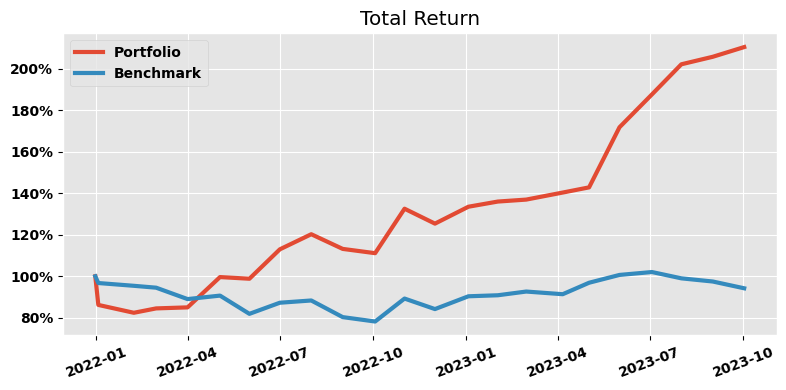

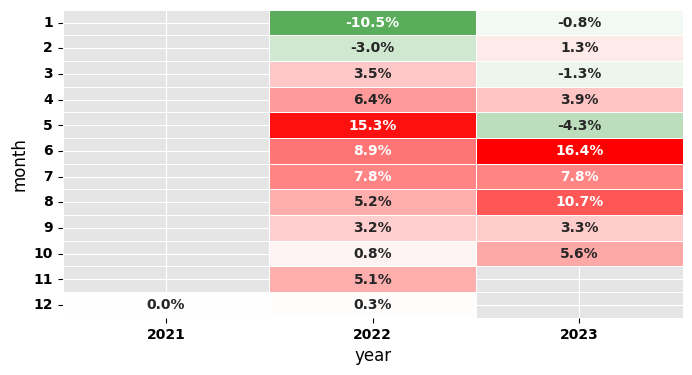

In [ ]:
# 績效指標
def perf_cal(df_tr, name_1, name_2):
    status = {}
    status['最大回撤'] = -((df_tr[name_1].cummax() - df_tr[name_1])/df_tr[name_1].cummax()).max()
    status['累積報酬'] = [df_tr[name_1].iloc[-1]]
    status['年化報酬'] = [(df_tr[name_1].iloc[-1] ** (12/len(df_tr))-1)]
    std = df_tr[name_2].std() * np.sqrt(12)
    status['Sharpe Ratio'] = status['年化報酬'] / std
    status = pd.DataFrame(status).transpose()
    status.columns = [name_1]
    return status

# 累積報酬圖
def plot_total_return(df_portfolio_tr,df_benchmark_tr, name):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(df_portfolio_tr.index, df_portfolio_tr['Portfolio Total Return'], label='Portfolio', linewidth=3)
    ax.plot(df_benchmark_tr.index, df_benchmark_tr['Benchmark Total Return'], label='Benchmark', linewidth=3)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
    plt.legend(loc='upper left')
    plt.title('Total Return')
    plt.xticks(rotation=20)
    plt.tight_layout()

# 月度勝率圖
def plot_monthly_return(df_portfolio_tr, df_benchmark_tr):
    df_portfolio_tr['year'] = df_portfolio_tr.index.year
    df_portfolio_tr['month'] = df_portfolio_tr.index.month
    df_benchmark_tr['year'] = df_benchmark_tr.index.year
    df_benchmark_tr['month'] = df_benchmark_tr.index.month
    rt_pivot_strategy = df_portfolio_tr.pivot(index='year', columns='month', values='Portfolio Return')
    rt_pivot_benchmark = df_benchmark_tr.pivot(index='year', columns='month', values='Benchmark Return')
    rt_pivot_excess = rt_pivot_strategy - rt_pivot_benchmark

    cmap1= LinearSegmentedColormap.from_list("custom", [(0, "green"), (0.5, "white"), (1, "red")])
    fig, ax = plt.subplots(figsize=(8,4))
    sns.heatmap(rt_pivot_excess.T,annot=True, xticklabels= True, yticklabels= True, cmap=cmap1, center=0, fmt='.1%', cbar=False, linewidths=0.5)
    plt.yticks(rotation=0)


# 呼叫績效呈現函式
plot_total_return(df_portfolio_tr,df_benchmark_tr, 'Portfolio_1')
plot_monthly_return(df_portfolio_tr, df_benchmark_tr)
portfolio_perf = perf_cal(df_portfolio_tr, 'Portfolio Total Return','Portfolio Return')
benchmark_perf = perf_cal(df_benchmark_tr, 'Benchmark Total Return','Benchmark Return')
summary_perf = pd.concat([portfolio_perf,benchmark_perf],axis=1)
summary_perf